In [1]:
%matplotlib inline 
from sklearn import cluster
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
from IPython.display import HTML
from IPython.display import Image
from ipywidgets import interact, interactive, fixed,widgets
from IPython.display import display

#HTML('''<script>
#code_show=true; 
#function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
#} 
#$( document ).ready(code_toggle);
#</script>
#The raw code for this IPython notebook is by default hidden for easier reading.
#To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')



In [2]:
%cd /mnt/bay1/bioinfo/combined_attempt/

/mnt/bay1/bioinfo/combined_attempt


# Data gathered from all BRCA patients
* All BRCA cancer samples were downloaded for TCGA resulting in expression profiles for 1102 patients
* Normal data was downloaded for 114 patients
    * For the 20532 genes median expression values were calculated.  These will function as baseline expression for the 1102 patients
* Fold change calculated for 1102 patients as log2(cancer exp/median normal exp) per 20532 genes.
* This allows for near complete overlap with protein data (106 patients, out of about 108)
## Gene selection and profiling

### Figure 1
Below is a plot of all genes for all patients, the x axis is the mrna fold change, the y axis is the protein fold change.  Each point represents the ratio of protein fold change to mRNA fold change.  The closer a point is to the top, the more up-expressed a protein was in cancer; towards the bottom it is down-expressed.  So if a point exists in the upper left quadrant, that gene for a specific patient had down-regulated mRNA and up-regulated protein.

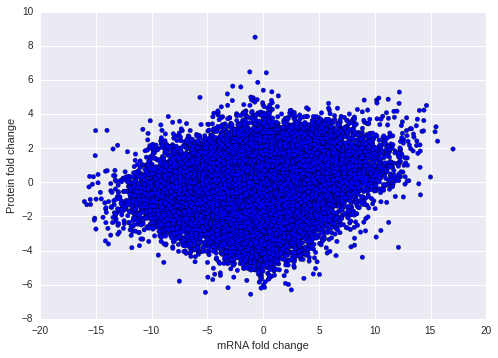

In [9]:
df = pd.read_csv(open("data/intermediate/merged_protein_mrna.txt",'r'),delimiter="\t")
plt.scatter(df['mrna'],df['prot'])
plt.ylabel("Protein fold change")
plt.xlabel("mRNA fold change")
plt.show()

### Figure 2
Below is a plot showing the mean representation of fold change for each gene.  Same as above, however this is a mean representation instead of patient-level data.  Here points are colored based on the pearson correlational score.  The distributions on the axes represent the protein fold change (y-axis) and mRNA fold change (x-axis).  Here we can see there are genes that have disparate levels of mRNA/Protein and consistently so.  For example a gene on the right hand portion of the plot indicates high mRNA levels, and lower protein.  However, as those mRNA levels increase so do those slightly lower protein.

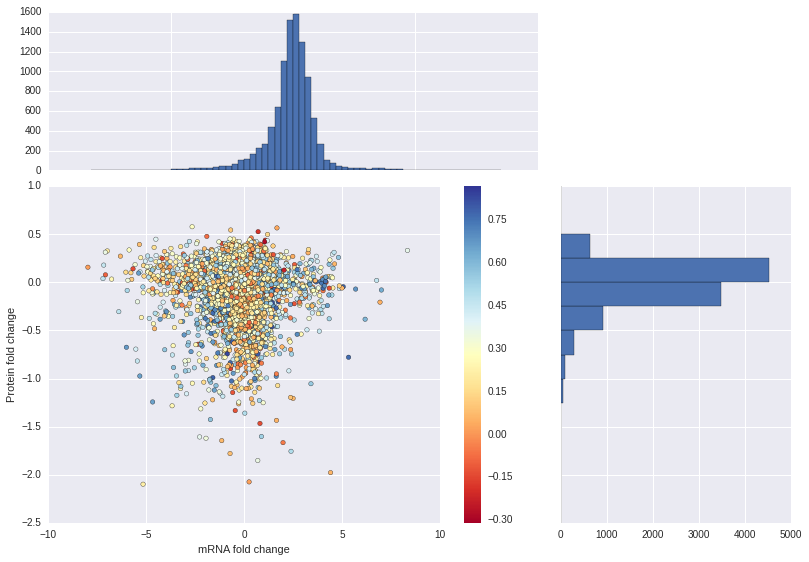

In [26]:
from matplotlib.ticker import NullFormatter

df2 = pd.read_csv(open("data/output/pearsonr_prot_mrna.txt",'r'),delimiter="\t")
cm = plt.cm.get_cmap('RdYlBu')

# definitions for the axes
nullfmt = NullFormatter()         # no labels

left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.4]
rect_histy = [left_h, bottom, 0.4, height]
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
binwidth = 0.25
xymax = np.max([np.max(np.fabs(df2['mrna_mean'])), np.max(np.fabs(df2['prot_mean']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(df2['mrna_mean'], bins=bins)
axHisty.hist(df2['prot_mean'], bins=bins, orientation='horizontal')

s = axScatter.scatter(df2['mrna_mean'],df2['prot_mean'],c=df2['stat'],cmap=cm)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
axScatter.set_xlabel("mRNA fold change")
axScatter.set_ylabel("Protein fold change")

plt.colorbar(mappable=s,ax=axScatter)
plt.show()

After observing these genes, we filter for those with the highest pearson correlation.  This identifies the following 30 genes that are further used for classifications.  These genes, when a functional enrichment has been performed emphasize breast cancer datasets.

In [27]:
gene_annotation = pd.read_csv(open("data/staging/hgnc_complete_set.txt",'r'),delimiter="\t")
df2['gene'][df2['stat'] >= 0.80].to_csv(open("data/intermediate/high_pearson.txt",'w'),sep="\t",index=False)
high_corr_genes = df2['gene'][df2['stat']>= 0.80]
df2_annotated = pd.merge(gene_annotation[['symbol','location','location_sortable']],df2,left_on='symbol',right_on='gene')
df2[df2['stat'] >= 0.80]



,gene,mrna_mean,prot_mean,pval,stat
116,ACSS1,0.236823,-0.136627,4.960114e-26,0.809507
237,AGR2,0.764832,-0.830289,5.820209e-26,0.808861
238,AGR3,0.060772,-0.460732,3.393239e-29,0.836537
290,AKR7A3,0.935461,-0.626903,4.067574e-25,0.800798
668,ASS1,-0.930884,-0.016816,1.205274e-33,0.867669
1175,CA12,0.095543,-0.481254,5.905257e-26,0.808802
1944,CRABP2,1.354652,-0.157611,1.197443e-28,0.832181
1947,CRAT,0.442587,-0.359067,3.656218e-28,0.828219
1973,CROT,-0.405355,-0.222228,9.654943e-28,0.824687
2569,EEF1A2,1.771364,-0.201388,2.688497e-25,0.802547


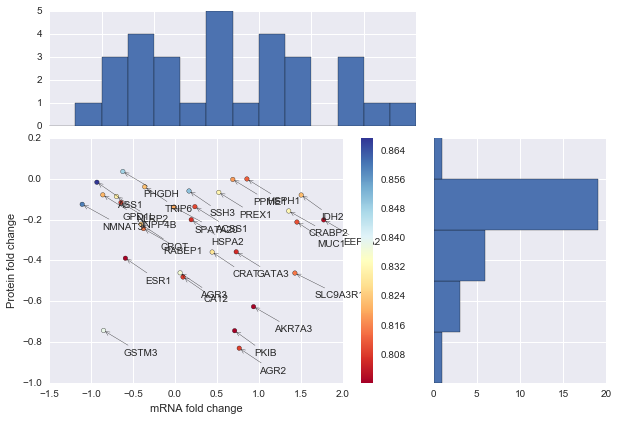

In [58]:
from matplotlib.ticker import NullFormatter

df2 = pd.read_csv(open("data/output/pearsonr_prot_mrna.txt",'r'),delimiter="\t")
df2 = df2[df2['gene'].isin(high_corr_genes)]
cm = plt.cm.get_cmap('RdYlBu')

# definitions for the axes
nullfmt = NullFormatter()         # no labels

left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.4]
rect_histy = [left_h, bottom, 0.4, height]
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
binwidth = 0.25
xymax = np.max([np.max(np.fabs(df2['mrna_mean'])), np.max(np.fabs(df2['prot_mean']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(df2['mrna_mean'], bins=bins)
axHisty.hist(df2['prot_mean'], bins=bins, orientation='horizontal')

s = axScatter.scatter(df2['mrna_mean'],df2['prot_mean'],c=df2['stat'],cmap=cm)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
axScatter.set_xlabel("mRNA fold change")
axScatter.set_ylabel("Protein fold change")

labels = list(df2['gene'])
for i, txt in enumerate(labels):
    axScatter.annotate(txt,xy=(list(df2['mrna_mean'])[i],list(df2['prot_mean'])[i]),
                      xytext = (20, -25),
        textcoords = 'offset points', 
       # bbox = dict(boxstyle = 'round,pad=0.5', fc = 'grey', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->'))
plt.colorbar(mappable=s,ax=axScatter)
plt.show()

### Figure 3
The following is the PCA done the same as previously (based on mRNA dysregulation) using the 30 genes and all 1102 patients.  Here we can see the partitioning of patients with overlap between two clusters.  The table shows the genes and their relative contributions to the PCA.

/usr/lib/python2.7/dist-packages/pandas/core/frame.py:1686: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


              PC-1      PC-2
ACSS1     0.030833 -0.011200
AGR2      0.405454 -0.037095
AGR3      0.408270 -0.005755
AKR7A3    0.270083  0.026001
ASS1     -0.112652  0.027710
CA12      0.282888 -0.027158
CRABP2    0.066637 -0.027739
CRAT      0.080568 -0.012449
CROT      0.093144 -0.028482
EEF1A2    0.279272  0.098334
ESR1      0.402586 -0.048803
GATA3     0.247370 -0.015757
GPD1L     0.094010  0.002144
GSTM3     0.130349 -0.015905
HSPA2     0.089651 -0.026258
HSPH1    -0.012815  0.000720
IDH2     -0.038191 -0.002443
INPP4B    0.178173 -0.041023
MUC1      0.117676 -0.017659
NLRP2    -0.041924 -0.988282
NMNAT3    0.059940 -0.016162
PHGDH    -0.156587 -0.004539
PKIB      0.140863  0.013075
PPME1    -0.002481  0.014732
PREX1     0.134536 -0.038817
RABEP1    0.099252 -0.013202
SLC9A3R1  0.093856 -0.005753
SPATA20   0.082867  0.006942
SSH3      0.075510 -0.003916
TRIP6    -0.036262 -0.012316

[30 rows x 2 columns]


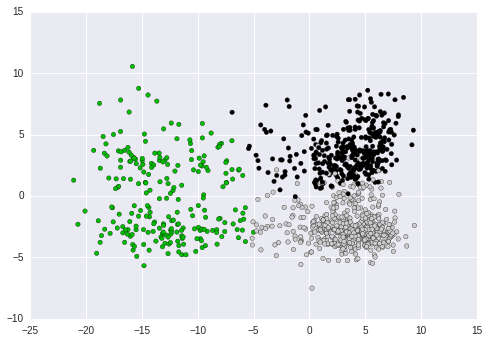

In [3]:
%run src/clustering_all_samples.py data/intermediate/high_pearson.txt data/intermediate/mrna_with_cluster_spearman.txt 2d

### Figure 4
Following is the 3D PCA.  Same 30 genes.

              PC-1      PC-2      PC-3
ACSS1     0.030833 -0.011200  0.019779
AGR2      0.405454 -0.037095  0.154061
AGR3      0.408270 -0.005755  0.332040
AKR7A3    0.270083  0.026001 -0.157999
ASS1     -0.112652  0.027710 -0.026685
CA12      0.282888 -0.027158  0.034914
CRABP2    0.066637 -0.027739 -0.047289
CRAT      0.080568 -0.012449  0.118734
CROT      0.093144 -0.028482  0.085969
EEF1A2    0.279272  0.098334 -0.868820
ESR1      0.402586 -0.048803  0.078360
GATA3     0.247370 -0.015757  0.009785
GPD1L     0.094010  0.002144 -0.000119
GSTM3     0.130349 -0.015905  0.020990
HSPA2     0.089651 -0.026258  0.070070
HSPH1    -0.012815  0.000720 -0.044000
IDH2     -0.038191 -0.002443 -0.045112
INPP4B    0.178173 -0.041023  0.034171
MUC1      0.117676 -0.017659  0.123049
NLRP2    -0.041924 -0.988282 -0.113635
NMNAT3    0.059940 -0.016162  0.056359
PHGDH    -0.156587 -0.004539  0.021057
PKIB      0.140863  0.013075  0.011222
PPME1    -0.002481  0.014732 -0.023037
PREX1     0.134536 -0.038

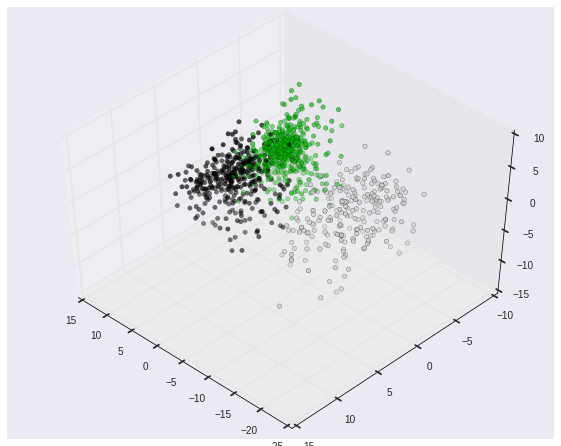

In [4]:
%run src/clustering_all_samples.py data/intermediate/high_pearson.txt data/intermediate/mrna_with_cluster_spearman_3d.txt 3d

### Figure 5
In an attempt to do more direct clustering based on mRNA fold change, I performed complete (UPGMA) hiearchial clustering, here columns are the samples (patients) rows are genes.  Each cell represents their mRNA fold change of 1 of the 30 genes selected because of high pearson correlation to protein levels.  We see an interesting difference in signature between the the first branches of the hiearchy. 

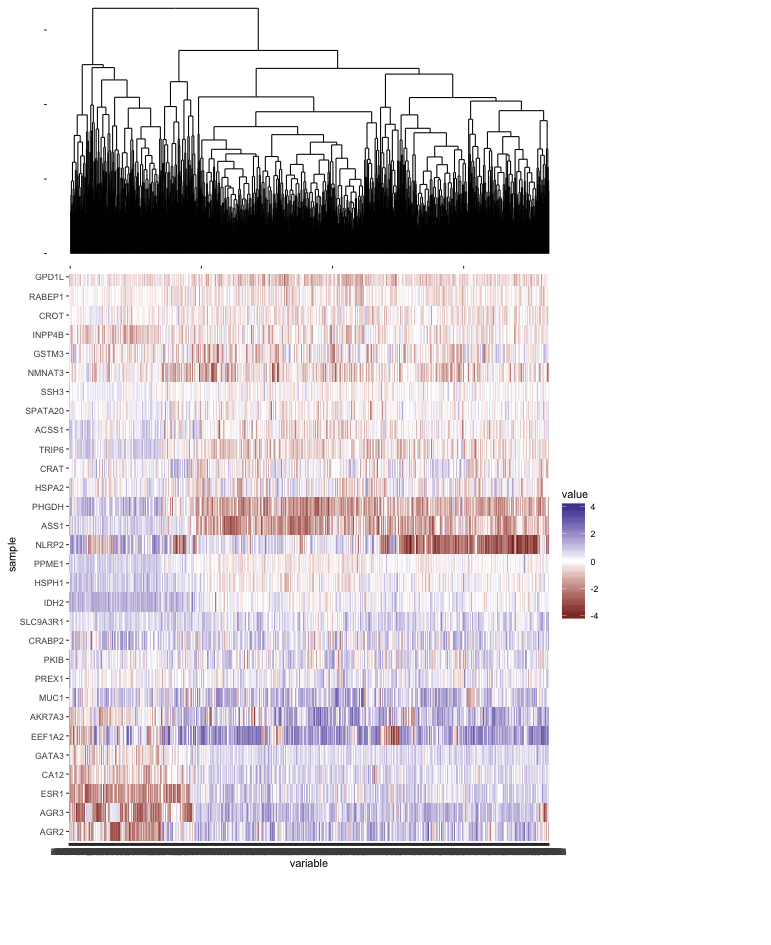

In [30]:
from IPython.display import Image
Image(filename='output/heatmap.png')

### Figure 6
Here I split the hiearchy to identify 3 different clusters (same as above).  The blue line represents the cut point, the red boxes the clusters.  The colored sections are the sample IDs, but due to the volume readability is an issue.  The changes in color help emphasize the different clusters.

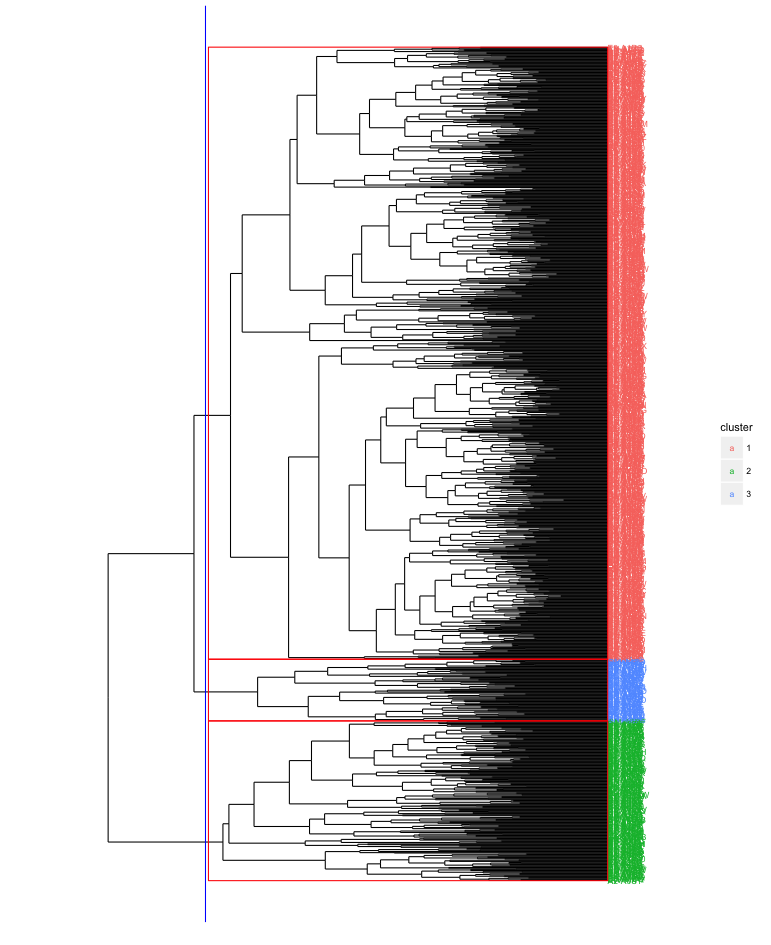

In [31]:
from IPython.display import Image
Image(filename='output/dendrogram.png')

### Figures 7 and 8
The first histogram shows the distribution of patients identified as ER positive.  We can see clusters 0 and 1 have a large volume of positive, while 2 does not.  Between 0 and 1, the amount of patients identified with positive ER status are equavalent when taking cluster size into consideration.

The second histogram illustrates the same ER status by cluster using the hiearchial clustering.  Here we see cluster 1 is has a large volume of positives, while others have hardly any.  This seems to suggest a particular signature of mRNA dysregulation, when considering equivalent protein expression can identify a subset of genes that may impact estrogen receptor functionality.

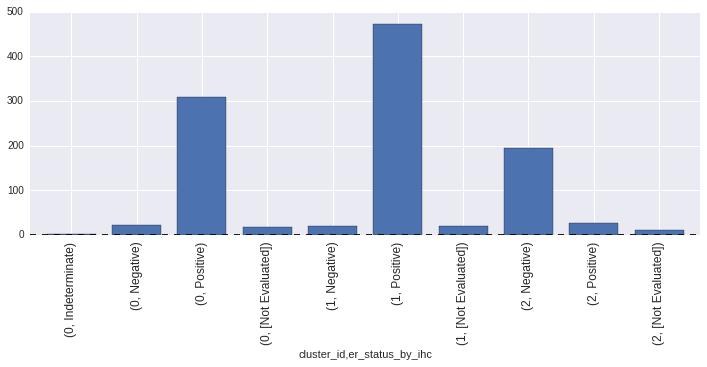

In [9]:
clustered_data = pd.read_csv(open("data/intermediate/mrna_with_cluster_spearman_3d.txt",'r'),delimiter="\t")
clustered_data.groupby(['cluster_id','er_status_by_ihc']).size().plot(kind="bar",figsize=(12,4))

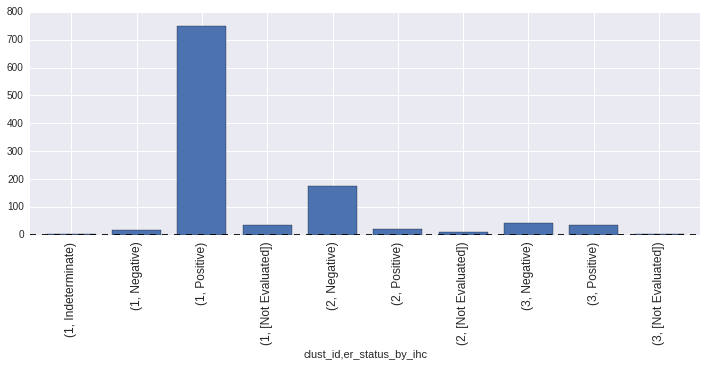

In [8]:
heir_cluster_data = pd.read_csv(open("data/intermediate/hiearchial_clusters_complete.txt",'r'),delimiter="\t")
merged_data = pd.merge(clustered_data,heir_cluster_data,left_on="Unnamed: 0",right_on="labels")
merged_data.groupby(['clust_id','er_status_by_ihc']).size().plot(kind="bar",figsize=(12,4))

## Protein and mRNA comparisons

In [54]:
df = pd.read_csv(open("data/intermediate/merged_protein_mrna.txt",'r'),delimiter="\t")
df = df[df['Gene'].isin(high_corr_genes)]
df['Gene']
df_mrna = pd.pivot_table(df[['Gene','Sample','mrna']],index='Sample',columns='Gene',values='mrna')
df_prot = pd.pivot_table(df[['Gene','Sample','prot']],index='Sample',columns='Gene',values='prot')

df_mrna.to_csv(open("data/intermediate/mrna_fold_change_matched.txt",'w'),sep="\t",row_index=False)
df_prot.to_csv(open("data/intermediate/prot_fold_change_matched.txt",'w'),sep="\t",row_index=False)

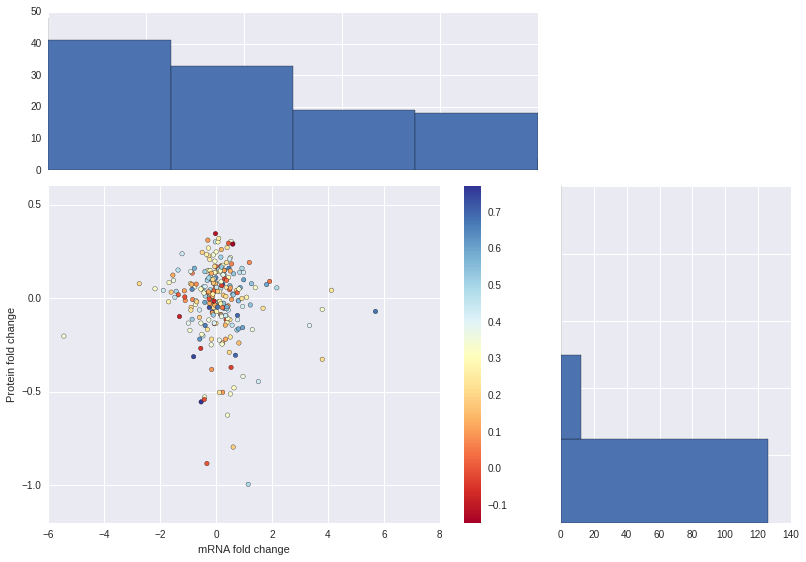

In [38]:
def location_check(loc_string):
    if '22q' in loc_string:
        return 1
    else:
        return 0
df2_annotated = pd.merge(gene_annotation[['symbol','location','location_sortable']],df2,left_on='symbol',right_on='gene')
df2_annotated['in_region'] = df2_annotated['location_sortable'].map(lambda x: (location_check(x)))

df3 = df2_annotated[df2_annotated['in_region'] == 1].reset_index()
cm = plt.cm.get_cmap('RdYlBu')


# definitions for the axes
nullfmt = NullFormatter()         # no labels
left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.4]
rect_histy = [left_h, bottom, 0.4, height]
axScatter2 = plt.axes(rect_scatter)
axHistx2 = plt.axes(rect_histx)
axHisty2 = plt.axes(rect_histy)
axHistx2.xaxis.set_major_formatter(nullfmt)
axHisty2.yaxis.set_major_formatter(nullfmt)
binwidth = 0.25
xymax = np.max([np.max(np.fabs(df3['mrna_mean'])), np.max(np.fabs(df3['prot_mean']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx2.hist(df3['mrna_mean'], bins=bins)
axHisty2.hist(df3['prot_mean'], bins=bins, orientation='horizontal')

s = axScatter2.scatter(df3['mrna_mean'],df3['prot_mean'],c=df3['stat'],cmap=cm)

axHistx2.set_xlim(axScatter.get_xlim())
axHisty2.set_ylim(axScatter.get_ylim())
axScatter2.set_xlabel("mRNA fold change")
axScatter2.set_ylabel("Protein fold change")

plt.colorbar(mappable=s,ax=axScatter2)
plt.show()